In [2]:
import os
from os.path import join

import nilearn as nl
import nibabel as nib
import numpy as np

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plotting']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## 8.1.4 Nilearn - Intro to fMRI decoding tutorial

In [3]:
from nilearn import datasets

In [4]:
# load the Haxby 2001 dataset
haxby_dataset = datasets.fetch_haxby()


fmri_filename = haxby_dataset.func[0]
print('first subject functional nifti images are at {}'.format(fmri_filename))


Dataset created in /Users/jeffmacinnes/nilearn_data/haxby2001



Downloaded 2969 of 2969 bytes (100.0%,    0.0s remaining) ...done. (5 seconds, 0 min)


Downloaded 408 of 408 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 291168628 of 291168628 bytes (100.0%,    0.0s remaining) ...done. (54 seconds, 0 min)
Extracting data from /Users/jeffmacinnes/nilearn_data/haxby2001/f33ff337e914bf7fded743c7107979f9/subj2-2010.01.14.tar.gz...

first subject functional nifti images are at /Users/jeffmacinnes/nilearn_data/haxby2001/subj2/bold.nii.gz


.. done.


### Convert fMRI volume to data matrix

In [10]:
mask_fname = haxby_dataset.mask_vt[0]

In [11]:
# visualize it
from nilearn import plotting

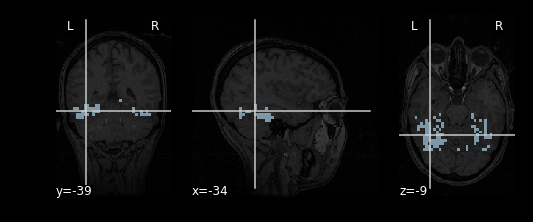

In [12]:
plotting.plot_roi(mask_fname, bg_img=haxby_dataset.anat[0],cmap='Paired')

In [13]:
# Next, create a masker. This will convert the data to a 2D array, as well 
# as apply any additional preprocessing steps you specify
from nilearn.input_data import NiftiMasker

In [14]:
# create a masker out of the mask and standarize the data. A masker is
# a transform that will convert the data from one form to another
masker = NiftiMasker(mask_img=mask_fname, standardize=True)

fmri_masked = masker.fit_transform(fmri_filename)

In [15]:
fmri_masked.shape

(1452, 464)

`fmri_masked` is now a 2D array that has been normalized

### Load behavioral data

In [24]:
import pandas as pd

In [27]:
behavioral = pd.read_csv(haxby_dataset.session_target[0], sep=' ')
behavioral.head(15)

,labels,chunks
0,rest,0
1,rest,0
2,rest,0
3,rest,0
4,rest,0
5,rest,0
6,scissors,0
7,scissors,0
8,scissors,0
9,scissors,0


In [31]:
# retrieve the conditions that are going to be the prediction targets
conditions = behavioral['labels']

# restrict the analysis to cat and faces conditions only
condition_mask = conditions.isin(['face', 'cat'])
condition_mask.shape

(1452,)

In [63]:
behavioral

,labels,chunks
0,rest,0
1,rest,0
2,rest,0
3,rest,0
4,rest,0
5,rest,0
6,scissors,0
7,scissors,0
8,scissors,0
9,scissors,0


In [32]:
# apply the condition_mask to the 2D dataset to isolate the samples we want
fmri_masked = fmri_masked[condition_mask]
fmri_masked.shape

(216, 464)

In [33]:
# mask the condition labels in the same way
conditions = conditions[condition_mask]
conditions.shape

(216,)

### Decode the dataset with an SVM
We now have a 2D dataset of features and samples. The features are the voxels in the mask, and the samples are the timepoints that we isolated that pertain to a specific trial type. In addition, we have a conditions vector that provides a label for each of the samples. This is all we need to start using scikit-learn 

In [34]:
# create the SVM decoder
from sklearn.svm import SVC

In [35]:
svc = SVC(kernel='linear')
print(svc)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


Note: the SVC is an object that can be fit or trained on labeled data, and then tested on unlabeled data

In [37]:
# first fit on the data
svc.fit(fmri_masked, conditions)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [38]:
# now predict the labels from the data
prediction = svc.predict(fmri_masked)
print(prediction)

['face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'cat' 'cat'
 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'face' 'face' 'face' 'face'
 'face' 'face' 'face' 'face' 'face' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat'
 'cat' 'cat' 'cat' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face'
 'face' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat'
 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'face' 'face' 'face' 'face'
 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face'
 'face' 'face' 'face' 'face' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat'
 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'face'
 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face'
 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'cat' 'cat' 'cat' 'cat'
 'cat' 'cat' 'cat' 'cat' 'cat' 'face' 'face' 'face' 'face' 'face' 'face'
 'face' 'face' 'face' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat'
 'face' 'face' 'face' 'face' 'face' 'face' 'face' '

In [41]:
# what's the error rate?
numCorrect = (prediction == conditions).sum()
errRate = numCorrect/float(len(conditions))
errRate

1.0

In [ ]:
# Crazy good error rate, yeah? Too bad it's invalid.
# We tested on the SAME data we trained on. Need to do something better. 

### Using Cross-validation

In [42]:
# leave out the 30 last data points during training, then test on those
svc.fit(fmri_masked[:-30], conditions[:-30])

# test on the left-out samples
prediction = svc.predict(fmri_masked[-30:])
print((prediction == conditions[-30:]).sum() / float(len(conditions[-30:])))

0.666666666667


In [43]:
# Ok, but choosing 30 samples is kinda arbitrary. Let's do K-fold instead
from sklearn.cross_validation import KFold

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [45]:
# set up the cross-validation 
cv = KFold(n=len(fmri_masked), n_folds=5)

for train, test in cv:
    conditions_masked = conditions.values[train]
    svc.fit(fmri_masked[train], conditions_masked)
    prediction = svc.predict(fmri_masked[test])
    print((prediction == conditions.values[test]).sum()
         / float(len(conditions.values[test])))

0.977272727273
0.767441860465
0.790697674419
0.53488372093
0.744186046512


In [46]:
# make cross-validation even easier

In [47]:
from sklearn.cross_validation import cross_val_score

In [48]:
cv_score = cross_val_score(svc, fmri_masked, conditions, cv=cv)
print(cv_score)

[ 0.97727273  0.76744186  0.79069767  0.53488372  0.74418605]


### Examining Model Weights

In [50]:
coef_ = svc.coef_
coef_.shape

(1, 464)

In [53]:
# We have these weights, 
# but we need to know WHERE in the brain these voxels were
# So, invert the masker
coef_img = masker.inverse_transform(coef_)
print(coef_img)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (40, 64, 64, 1)
affine: 
[[  -3.5      0.       0.      68.25 ]
 [   0.       3.75     0.    -118.125]
 [   0.       0.       3.75  -118.125]
 [   0.       0.       0.       1.   ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [ 4 40 64 64  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [-1.    3.5   3.75  3.75  1.    1.    1.    1.  ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_f

In [54]:
from nilearn.plotting import plot_stat_map, show

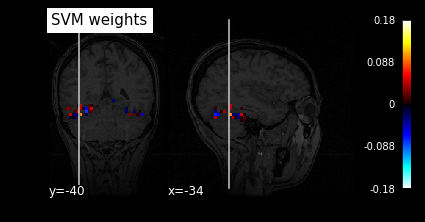

In [58]:
plot_stat_map(coef_img, bg_img=haxby_dataset.anat[0],
              title="SVM weights", display_mode="yx")
show()

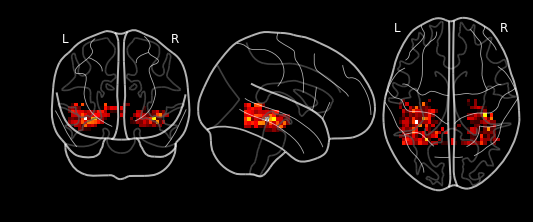

In [62]:
plotting.plot_glass_brain(coef_img, black_bg=True)